# 一、数据集和数据加载器
- 用于处理数据样本的代码可能会变得混乱且难以维护；理想情况下，我们希望数据集代码与模型训练代码分离，以获得更好的可读性和模块化性。
- PyTorch 提供了两个数据原语：torch.utils.data.DataLoader 和 torch.utils.data.Dataset，允许您使用预加载的数据集以及您自己的数据。
- Dataset 存储样本及其相应的标签，DataLoader 围绕 Dataset 包装一个可迭代对象，以便轻松访问样本。
- PyTorch 域库提供了许多预加载的数据集（例如 FashionMNIST），它们是 torch.utils.data.Dataset 的子类并实现特定于特定数据的函数。
- 它们可用于对您的模型进行原型设计和基准测试。您可以在这里找到它们：图像数据集、文本数据集和音频数据集


## 1、加载数据集
- 以下是如何从 TorchVision 加载 Fashion-MNIST 数据集的示例。
- Fashion-MNIST 是 Zalando 文章图像的数据集，由 60,000 个训练示例和 10,000 个测试示例组成。
- 每个示例包含一个 28×28 灰度图像和来自 10 个类别之一的关联标签。
- 

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# root 是存储训练/测试数据的路径， train 指定训练或测试数据集， download=True 如果根目录下没有数据，则从互联网下载数据。
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
# transform 和 target_transform 指定特征和标签变换
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 2、迭代和可视化数据集
- 我们可以像列表一样手动索引数据集：training_data[index]。我们使用 matplotlib 来可视化训练数据中的一些样本。

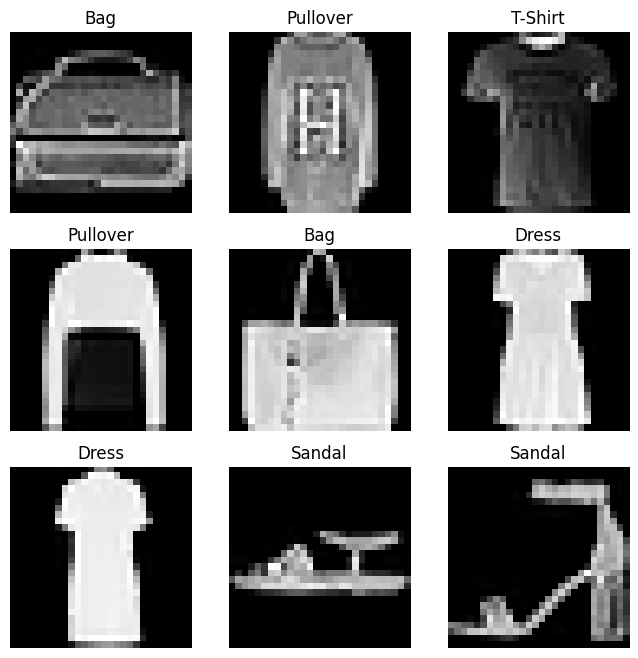

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 3、为您的文件创建自定义数据集
- 自定义 Dataset 类必须实现三个函数：__init__、__len__ 和 __getitem__。
- 看看这个实现； FashionMNIST图像存储在目录img_dir中，它们的标签单独存储在CSV文件annotations_file中。

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# 二、使用 DataLoaders 准备数据以进行训练
- 数据集检索数据集的特征并一次标记一个样本。
- 在训练模型时，我们通常希望以“小批量”方式传递样本，在每个时期重新整理数据以减少模型过度拟合，并使用 Python 的多重处理来加速数据检索。
- DataLoader 是一个可迭代对象，它通过一个简单的 API 为我们抽象了这种复杂性。

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 1、遍历 DataLoader
- 我们已将该数据集加载到 DataLoader 中，并且可以根据需要迭代数据集。
- 下面的每次迭代都会返回一批train_features和train_labels（分别包含batch_size = 64个特征和标签）。
- 因为我们指定了 shuffle=True，所以在迭代所有批次后，数据会被打乱（为了更细粒度地控制数据加载顺序，请查看 Samplers）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


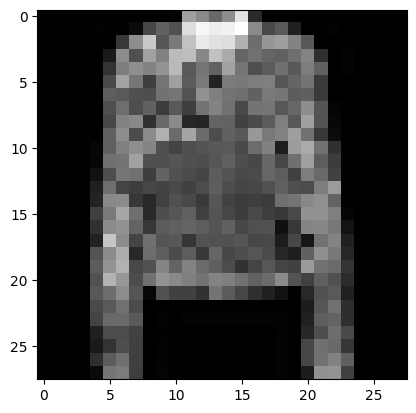

Label: 4


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")